In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import v2
import torchvision.models as models
import os
import timm
import glob
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [2]:
print(f'Torch-Version {torch.__version__}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')

Torch-Version 2.4.0
DEVICE: cuda


In [ ]:
#定义了一个自定义的transform，用于生成两个随机裁剪的图像作为查询和键
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views
    
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape
strength=1.0

color_jitter = v2.ColorJitter(0.8 * strength, 0.8 * strength, 0.8 * strength, 0.2 * strength)
gaussian_blur = v2.GaussianBlur(kernel_size=kernel_size)
image_transform = v2.Compose([
        v2.RandomResizedCrop(output_shape),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomApply([color_jitter], p=0.8),
        v2.RandomGrayscale(p=0.2),
        v2.RandomApply([gaussian_blur], p=0.5),
        v2.PILToTensor(), 
        v2.ToDtype(torch.float32, scale=True),
])

# The custom transform
custom_transform = ContrastiveLearningViewGenerator(base_transform=image_transform)

In [ ]:
#该部分定义了一个自定义的数据集类，用于加载数据集
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, folder_classes, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.folder_classes = folder_classes
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path = self.list_images[idx]
        folder_name = os.path.basename(os.path.dirname(img_path))
        
        # Get label for downstream task later
        if folder_name in self.folder_classes:
            label = self.folder_classes.index(folder_name)
        else:
            raise ValueError(f"Folder {folder_name} not found in folder_classes.")
        
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# List all images paths from the dataset directory
root_dir = "/kaggle/input/flowers"
#使用glob模块获取所有图像的路径
list_images = glob.glob(f"{root_dir}/*/*.jpg")

# Group images by their folder (class)
image_groups = {}
for img in list_images:
    folder_name = os.path.basename(os.path.dirname(img))
    if folder_name not in image_groups:
        image_groups[folder_name] = []
    image_groups[folder_name].append(img)

# Cross validation
val_ratio = 0.15

train_images = []
val_images = []

for folder, images in image_groups.items():
    
    # Split images
    train, val = train_test_split(images, test_size=val_ratio, random_state=42)
    
    # Add the images to the respective lists
    train_images.extend(train)
    val_images.extend(val)

print(f"Total number of training images: {len(train_images)}")
print(f"Total number of validation images: {len(val_images)}")

folder_classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Now create datasets
#创建数据集，包括两部分，一部分是训练数据集，一部分是验证数据集
train_flowers_ds = CustomDataset(train_images, folder_classes, transform=custom_transform)
val_flowers_ds = CustomDataset(val_images, folder_classes, transform=custom_transform)

Total number of training images: 3668
Total number of validation images: 649


In [6]:
'''
# Get the image paths from both datasets
train_image_paths = set(train_flowers_ds.list_images)
val_image_paths = set(val_flowers_ds.list_images)

# Check for any common paths
common_paths = train_image_paths.intersection(val_image_paths)

# Print out the results
if common_paths:
    print(f"Found {len(common_paths)} common image paths between training and validation datasets:")
    for path in common_paths:
        print(path)
else:
    print("No common image paths found between training and validation datasets.")
'''

'\n# Get the image paths from both datasets\ntrain_image_paths = set(train_flowers_ds.list_images)\nval_image_paths = set(val_flowers_ds.list_images)\n\n# Check for any common paths\ncommon_paths = train_image_paths.intersection(val_image_paths)\n\n# Print out the results\nif common_paths:\n    print(f"Found {len(common_paths)} common image paths between training and validation datasets:")\n    for path in common_paths:\n        print(path)\nelse:\n    print("No common image paths found between training and validation datasets.")\n'

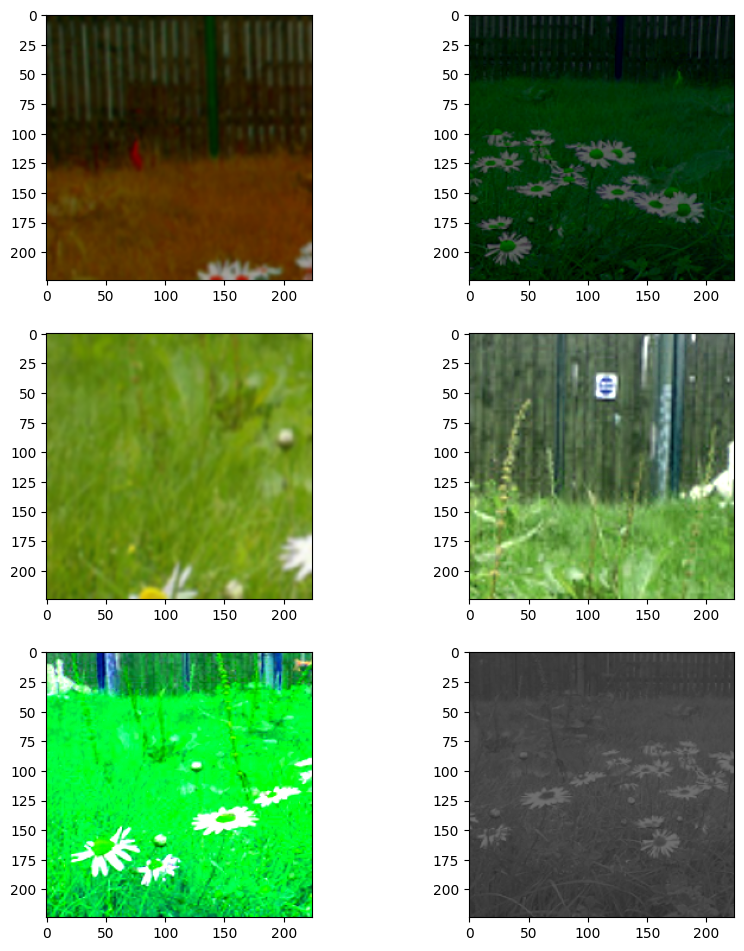

In [7]:
plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,4):
        batch = flowers[index]
        view1, view2 = batch[0]
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(train_flowers_ds,1000)

In [ ]:
BATCH_SIZE = 158

# Building the data loader
#使用DataLoader加载数据集，获得训练数据集和验证数据集
train_dl = DataLoader(train_flowers_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), drop_last=True, pin_memory=True)
val_dl = DataLoader(val_flowers_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), drop_last=True, pin_memory=True)

In [9]:
class MoCo_v1(nn.Module):
    def __init__(self, encoder, input_dim, hidden_dim, feature_dim, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        
        # Use the provided encoder
        self.encoder = encoder
        
        # projection head
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, feature_dim)
        )

    def forward(self, x):
        # Pass through encoder
        encoding = self.encoder(x)
        encoding = torch.flatten(encoding, start_dim=1)
        
        # Pass through projection head
        projection = self.projection(encoding)
        
        if self.linear_eval:
            return projection
        
        return F.normalize(projection, dim=-1)

In [ ]:
temperature, momentum = 2, 0.99

def train_and_validate(encoder_q, encoder_k, train_loader, validation_loader, criterion, optimizer, epochs=5, max_lr=0.01, train_loss_threshold=None, verbose=True, downstream_task = False):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False
    global memory_queue    

    # Calculate the total number of steps in one cycle (total batches across all epochs)
    total_steps = epochs * len(train_loader)
    
    # Define the OneCycleLR scheduler
    #使用OneCycleLR调度器
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps)
    #若是使用其他的调度器，比如StepLR，可以使用下面的代码
    #scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    
    for e in range(epochs):

        train_running_loss = 0.0
        validation_running_loss = 0.0
        
        if early_stop:
            break
        #train()函数用于启用训练模式
        encoder_q.train()
        # Training loop
        for ith_batch, sample_batched in enumerate(train_loader):
            views, labels = sample_batched
            if not downstream_task:
                x_q, x_k = views
                x_q, x_k = x_q.to(device, non_blocking=True), x_k.to(device, non_blocking=True)
                
                query = encoder_q(x_q)
                
                 # shuffle BN
                idx = torch.randperm(x_k.size(0), device=device)
                key = encoder_k(x_k[idx])
                key = key[torch.argsort(idx)]
                
                score_pos = torch.bmm(query.unsqueeze(dim=1), key.unsqueeze(dim=-1)).squeeze(dim=-1)
                score_neg = torch.mm(query, memory_queue.t().contiguous())
                
                # [B, 1+M]
                out = torch.cat([score_pos, score_neg], dim=-1)

                # compute loss
                loss = F.cross_entropy(out / temperature, torch.zeros(x_q.size(0), dtype=torch.long, device=device))
                
            else:
                images = views.to(device)
                labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32).to(device)
                pred = encoder_q(images)
                loss = criterion(pred, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if not downstream_task:
                # momentum update
                for parameter_q, parameter_k in zip(encoder_q.parameters(), encoder_k.parameters()):
                    parameter_k.data.copy_(parameter_k.data * momentum + parameter_q.data * (1.0 - momentum))

                # update queue
                memory_queue = torch.cat((memory_queue, key), dim=0)[key.size(0):]  # add current batch keys, remove oldest

            train_running_loss += loss.item()
            
            # Step the scheduler
            scheduler.step()
            lr_history.append(optimizer.param_groups[0]['lr'])

        # Validation loop
        with torch.no_grad():
            encoder_q.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                views, labels = sample_batched
                if not downstream_task:
                    x_q, x_k = views
                    x_q, x_k = x_q.to(device, non_blocking=True), x_k.to(device, non_blocking=True)
                    
                    query = encoder_q(x_q)
                
                     # shuffle BN
                    idx = torch.randperm(x_k.size(0), device=device)
                    key = encoder_k(x_k[idx])
                    key = key[torch.argsort(idx)]

                    score_pos = torch.bmm(query.unsqueeze(dim=1), key.unsqueeze(dim=-1)).squeeze(dim=-1)
                    score_neg = torch.mm(query, memory_queue.t().contiguous())

                    # [B, 1+M]
                    out = torch.cat([score_pos, score_neg], dim=-1)

                    # compute loss
                    val_loss = F.cross_entropy(out / temperature, torch.zeros(x_q.size(0), dtype=torch.long, device=device))
                    
                else:
                    images = views.to(device)
                    labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32).to(device)
                    pred = encoder_q(images)
                    val_loss = criterion(pred, labels)
                
                validation_running_loss += val_loss.item()

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)
            
            if verbose:
                print("================================================================================")
                print(f"Epoch {e + 1} completed")
                print(f"Average train loss: {train_epoch_loss}")
                print(f"Average validation loss: {validation_epoch_loss}")
                print("================================================================================")
            
            if train_loss_threshold is not None:
                if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                    print("Stopping training as training loss is below threshold and validation loss has stopped decreasing.")
                    early_stop = True
                prev_val_loss = validation_epoch_loss

        torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
negative_samples = 5 * BATCH_SIZE
learning_rate = 0.001
weight_decay = 0.01
epochs = 15

#定义了一个预训练的MobileNet编码器，MOCO中还可使用resnet系列的编码器，包括resnet18、resnet50等
#但是使用更复杂的网络可能会导致训练时间过长
def create_mobilenet_encoder():
    # Load the pre-trained MobileNet model
    mobilenet = timm.create_model('mobilenetv3_large_100.miil_in21k_ft_in1k', pretrained=True)
    #若是使用其他编码器，可以使用下面的代码
    #mobilenet = models.resnet50(pretrained=True)
    #或是使用下面的代码
    #mobilenet = models.resnet18(pretrained=True)
    # Remove the classifier layer
    mobilenet.classifier = nn.Identity()
    
    return mobilenet

# Define project layers
input_dim, hidden_dim, feature_dim = 1280, 512, 256

# Define keys and queries encoders
model_q = MoCo_v1(create_mobilenet_encoder(), input_dim, hidden_dim, feature_dim).to(device)
model_k = MoCo_v1(create_mobilenet_encoder(), input_dim, hidden_dim, feature_dim).to(device)
#输出网络的结构
print(model_q)

# do not update keys by gradient
for param_q, param_k in zip(model_q.parameters(), model_k.parameters()):
    param_k.data.copy_(param_q.data)
    param_k.requires_grad = False
    
# init memory queue as unit random vector ---> [M, D]
memory_queue = F.normalize(torch.randn(negative_samples, feature_dim).to(device), dim=-1)

optimizer = optim.AdamW(model_q.parameters(), lr=learning_rate/10, weight_decay=weight_decay)
train_and_validate(model_q, model_k, train_dl, val_dl, None, optimizer, epochs, learning_rate)

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Epoch 1 completed
Average train loss: 6.553667794103208
Average validation loss: 6.5759347677230835
Epoch 2 completed
Average train loss: 6.50978248015694
Average validation loss: 6.523038148880005
Epoch 3 completed
Average train loss: 6.438904907392419
Average validation loss: 6.47284734249115


In [ ]:
BATCH_SIZE = 128

classi_train_ds = CustomDataset(train_images, folder_classes, transform=image_transform)
classi_val_ds = CustomDataset(val_images, folder_classes, transform=image_transform)

classi_train_dl = DataLoader(classi_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), drop_last=True, pin_memory=True)
classi_val_dl = DataLoader(classi_val_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), drop_last=True, pin_memory=True)

num_classes = len(folder_classes)

In [ ]:
class LinearEvaluation(nn.Module):
    def __init__(self, model, num_classes, input_dim):
        super().__init__()
        moco_v1 = model
        moco_v1.linear_eval = True
        moco_v1.projection = nn.Identity()
        self.moco_v1 = moco_v1
        for param in self.moco_v1.parameters():
            param.requires_grad = False
            
        # Define a maximum threshold of 512 for the hidden layer size
        hidden_dim = min(input_dim // 2, 512)

        # Define linear layers using input_dim, applying integer division
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear3 = nn.Linear(hidden_dim // 2, num_classes)

        # Define batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        
    def forward(self, x):
        encoding = self.moco_v1(x)
        x = self.linear1(encoding)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        pred = self.linear3(x)
        return pred

In [ ]:
learning_rate = 0.0005
weight_decay = 0.01
epochs = 10

eval_model_q = LinearEvaluation(model_q, num_classes, input_dim).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(eval_model_q.parameters(), lr=learning_rate/10, weight_decay=weight_decay)

train_and_validate(eval_model_q, None, classi_train_dl, classi_val_dl, criterion, optimizer, epochs, learning_rate, downstream_task=True)

In [ ]:
from collections import Counter
from tqdm import tqdm

def evaluate_F1_with_multiple_loaders(model, validation_data, n_votes=5):
    # Create a list of DataLoader objects for majority voting
    validation_loaders = [DataLoader(validation_data, batch_size=1, num_workers=os.cpu_count()) for _ in range(n_votes)]

    with torch.no_grad():
        model.eval()

        actual_values = []
        predicted_values = []

        # Initialize a dictionary to store predictions for each sample
        vote_predictions = {}

        # Iterate through each DataLoader
        for i, loader in enumerate(tqdm(validation_loaders, desc="DataLoader Iterations", leave=False)):

            for idx, batch in enumerate(loader):
                X_val, y_val = batch
                X_val = X_val.to(device)

                # Forward pass
                y_pred = model(X_val)
                predicted_value = np.argmax(y_pred.cpu().numpy())

                # Store actual value only once (from the first iteration)
                if i == 0:
                    actual_values.append(y_val.cpu().numpy())

                # Collect predictions across the loaders for each sample
                if idx not in vote_predictions:
                    vote_predictions[idx] = []
                vote_predictions[idx].append(predicted_value)

        # Perform majority voting on collected predictions
        for idx in range(len(actual_values)):
            majority_prediction = Counter(vote_predictions[idx]).most_common(1)[0][0]
            predicted_values.append(majority_prediction)

    # Flatten actual values since they are arrays of shape (1,) after the first iteration
    actual_values = np.concatenate(actual_values, axis=0)

    # Calculate classification report
    print("Classification Report:")
    print(classification_report(actual_values, predicted_values, zero_division=1))

    # Calculate final F1 score and Accuracy
    final_f1_score = f1_score(actual_values, predicted_values, average='weighted')
    final_accuracy = accuracy_score(actual_values, predicted_values)

    print(f"\nFinal F1 Score (Weighted): {final_f1_score:.4f}")
    print(f"Final Accuracy: {final_accuracy:.4f}")

# Evaluate using majority voting with multiple DataLoaders
evaluate_F1_with_multiple_loaders(eval_model_q, classi_val_dl.dataset, n_votes=15)